In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

dataset/.DS_Store
dataset/Submission.csv
dataset/fer2013/.DS_Store
dataset/fer2013/fer2013/fer2013.csv
dataset/fer2013/fer2013/fer2013.bib
dataset/fer2013/fer2013/README


In [32]:
import math
import numpy as np
import pandas as pd

# import scikitplot  # Commented out due to compatibility issues with newer scipy
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [33]:
df = pd.read_csv('dataset/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [34]:
# Check unique emotion labels in the dataset
# First check if df exists, if not, load the data
try:
    df
except NameError:
    print("⚠️  Please run Cell 2 first to load the dataset!")
    df = pd.read_csv('dataset/fer2013/fer2013/fer2013.csv')
    print("✓ Dataset loaded successfully\n")

print("Unique emotion labels:", sorted(df.emotion.unique()))
print("\nEmotion mapping:")
emotion_mapping = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'sadness', 5:'surprise', 6:'neutral'}
for emo_id in sorted(df.emotion.unique()):
    print(f"  {emo_id}: {emotion_mapping[emo_id]}")

# Show count of each emotion
print("\nEmotion distribution:")
print(df.emotion.value_counts().sort_index())

Unique emotion labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Emotion mapping:
  0: anger
  1: disgust
  2: fear
  3: happiness
  4: sadness
  5: surprise
  6: neutral

Emotion distribution:
emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: count, dtype: int64


In [35]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [36]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

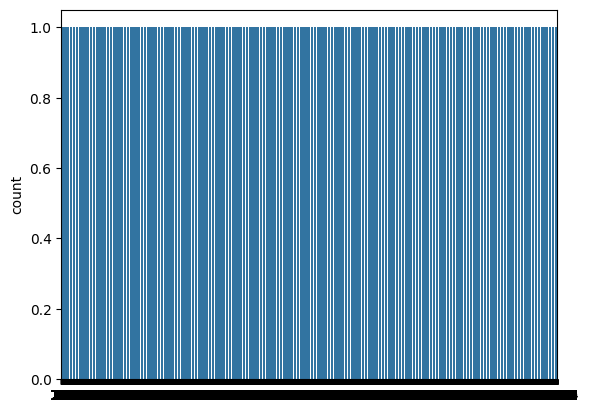

In [37]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [38]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

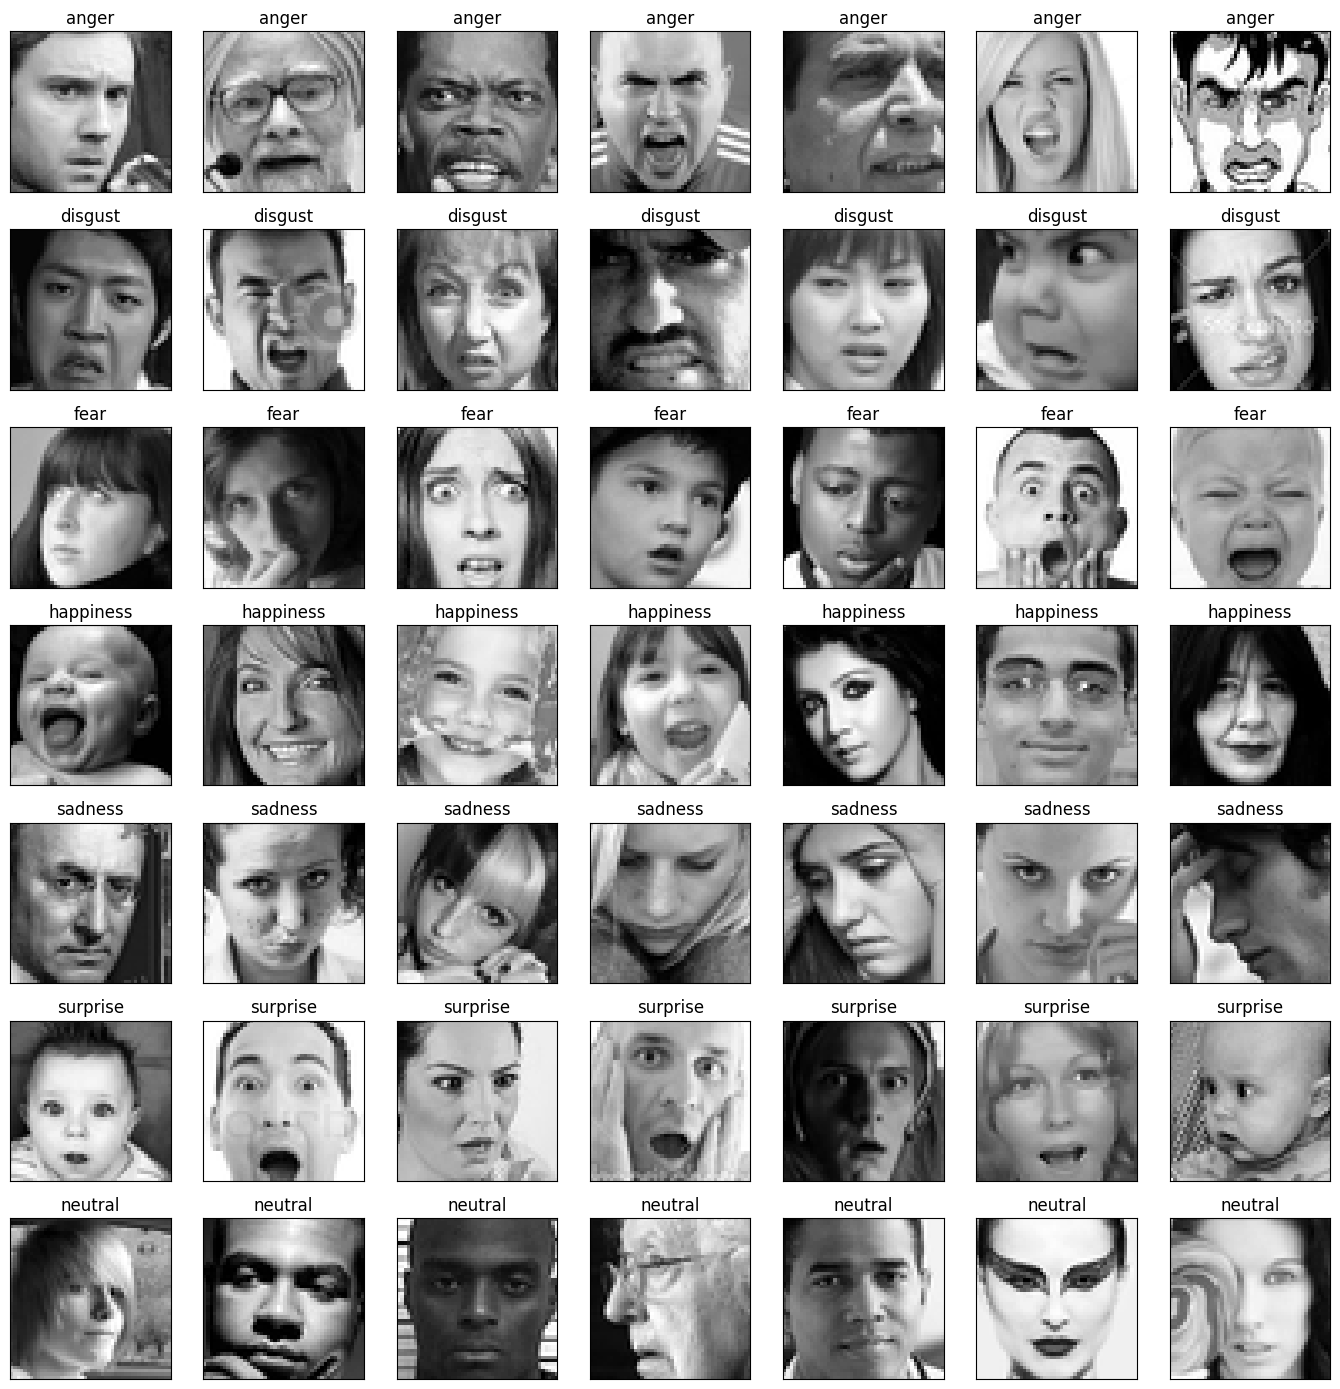

In [39]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [40]:
INTERESTED_LABELS = [3, 4, 6]

In [41]:
# Check if INTERESTED_LABELS is defined, if not, define it
try:
    INTERESTED_LABELS
except NameError:
    print("⚠️  Defining INTERESTED_LABELS...")
    INTERESTED_LABELS = [3, 4, 6]  # happiness, sadness, neutral
    print("✓ Using emotions: Happy (3), Sad (4), Neutral (6)\n")

# Filter dataset to only include interested emotions
df = df[df.emotion.isin(INTERESTED_LABELS)]
print(f"Dataset shape after filtering: {df.shape}")
print(f"Emotions in filtered dataset: {sorted(df.emotion.unique())}")
df.shape

Dataset shape after filtering: (21264, 3)
Emotions in filtered dataset: [np.int64(3), np.int64(4), np.int64(6)]


(21264, 3)

`Now I will make the data compatible for neural networks.`

In [42]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [43]:
img_array.shape

(21264, 48, 48, 1)

In [44]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [45]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(6): np.int64(2)}


`Splitting the data into training and validation set.`

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [47]:
del df
del img_array
del img_labels

In [48]:
# Define image dimensions and number of classes from training data
try:
    # Check if variables already exist
    _ = img_width
    print("✓ Image dimensions already defined")
    print(f"  Image size: {img_width}x{img_height}")
    print(f"  Depth (channels): {img_depth}")
    print(f"  Number of classes: {num_classes}\n")
except NameError:
    # Variables don't exist, define them from X_train and y_train
    print("⚠️  Defining image dimensions from training data...")
    img_width = X_train.shape[1]
    img_height = X_train.shape[2]
    img_depth = X_train.shape[3]
    num_classes = y_train.shape[1]
    print("✓ Image dimensions defined")
    print(f"  Image size: {img_width}x{img_height}")
    print(f"  Depth (channels): {img_depth}")
    print(f"  Number of classes: {num_classes}\n")

⚠️  Defining image dimensions from training data...
✓ Image dimensions defined
  Image size: 48x48
  Depth (channels): 1
  Number of classes: 3



In [49]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [50]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [51]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [52]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [55]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1291s 2s/step - accuracy: 0.4154 - loss: 1.2957 - val_accuracy: 0.5289 - val_loss: 0.9645 - learning_rate: 0.0010
Epoch 2/100
  1/598 ━━━━━━━━━━━━━━━━━━━━ 20:12 2s/step - accuracy: 0.4688 - loss: 1.1035

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


598/598 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.4688 - loss: 1.1035 - val_accuracy: 0.5294 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1151s 2s/step - accuracy: 0.5118 - loss: 0.9886 - val_accuracy: 0.5543 - val_loss: 0.9038 - learning_rate: 0.0010
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5000 - loss: 1.0133 - val_accuracy: 0.5472 - val_loss: 0.9132 - learning_rate: 0.0010
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1255s 2s/step - accuracy: 0.5740 - loss: 0.8802 - val_accuracy: 0.6582 - val_loss: 0.7499 - learning_rate: 0.0010
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.5000 - loss: 0.8621 - val_accuracy: 0.6671 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1269s 2s/step - accuracy: 0.6329 - loss: 0.7835 - val_accuracy: 0.6747 - val_loss: 0.7284 - learning_rate: 0.0010
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.5625 - loss: 

In [56]:
# Save model architecture as JSON (to_yaml is deprecated in newer Keras versions)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the entire model (weights + architecture)
model.save("model.h5")
print("Model saved as 'model.h5' and architecture saved as 'model.json'")

Model saved as 'model.h5' and architecture saved as 'model.json'


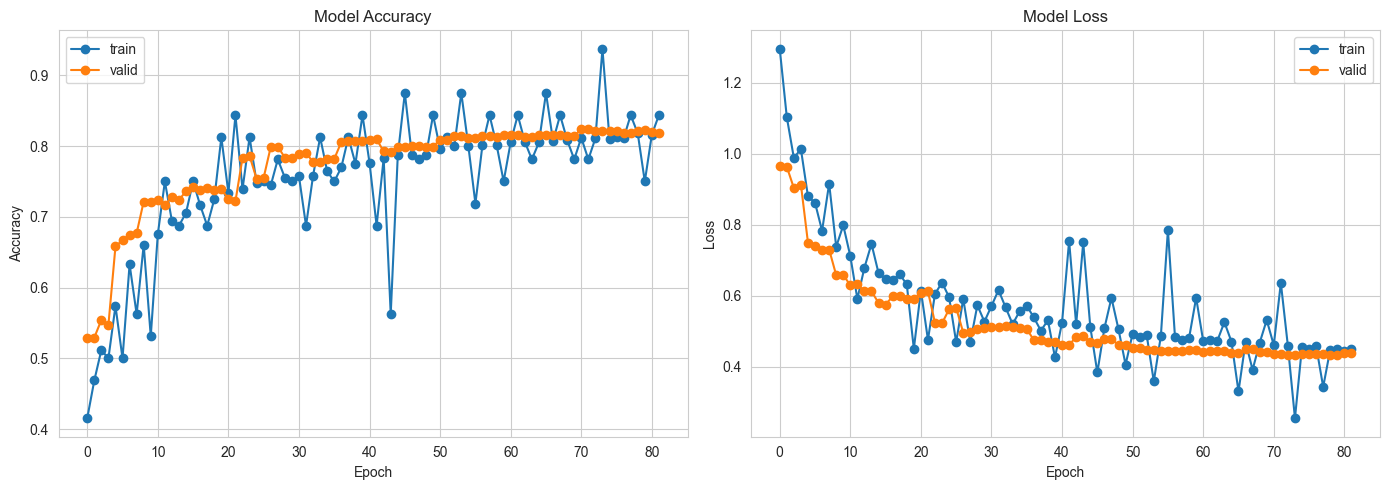

In [57]:
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.epoch, history.history['accuracy'], label='train', marker='o')
axes[0].plot(history.epoch, history.history['val_accuracy'], label='valid', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.epoch, history.history['loss'], label='train', marker='o')
axes[1].plot(history.epoch, history.history['val_loss'], label='valid', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png', dpi=150)
plt.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

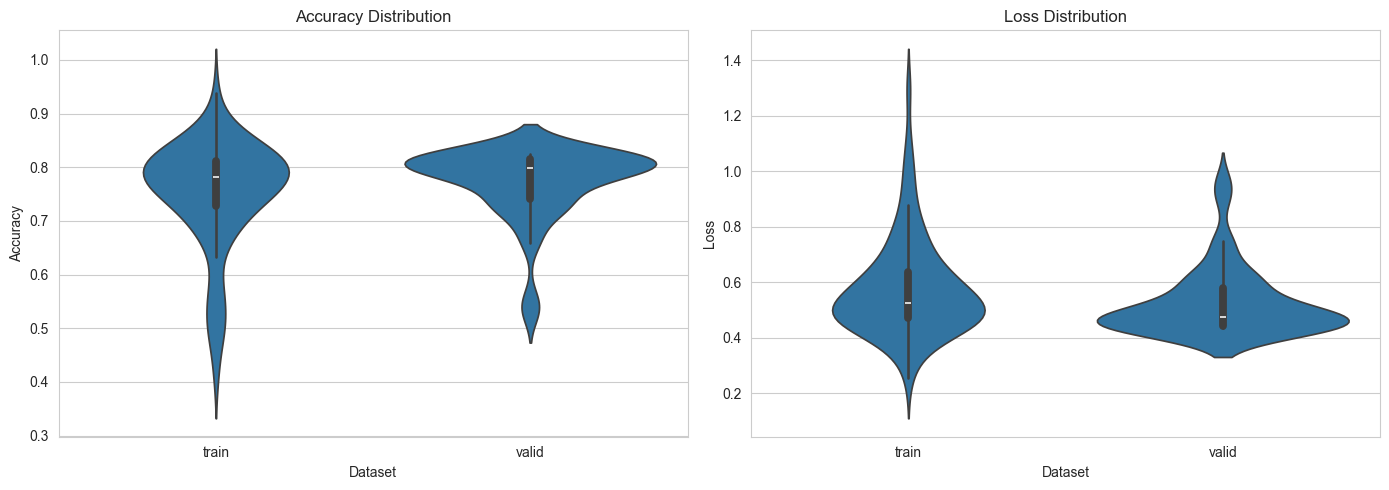

In [58]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy distribution
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), ax=axes[0])
axes[0].set_title('Accuracy Distribution')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Accuracy')

# Plot loss distribution
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), ax=axes[1])
axes[1].set_title('Loss Distribution')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('performance_dist.png', dpi=150)
plt.show()

total wrong validation predictions: 373


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       899
           1       0.78      0.73      0.75       608
           2       0.71      0.79      0.75       620

    accuracy                           0.82      2127
   macro avg       0.81      0.81      0.81      2127
weighted avg       0.83      0.82      0.83      2127



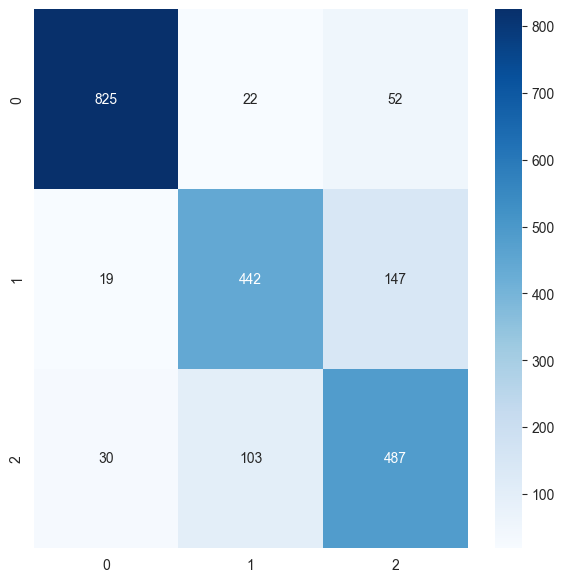

In [59]:
# Use model.predict() instead of deprecated predict_classes()
yhat_valid_probs = model.predict(X_valid, verbose=0)
yhat_valid = np.argmax(yhat_valid_probs, axis=1)

# Use sklearn's confusion matrix instead of scikitplot
cm = confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid)
fig, ax = pyplot.subplots(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [60]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

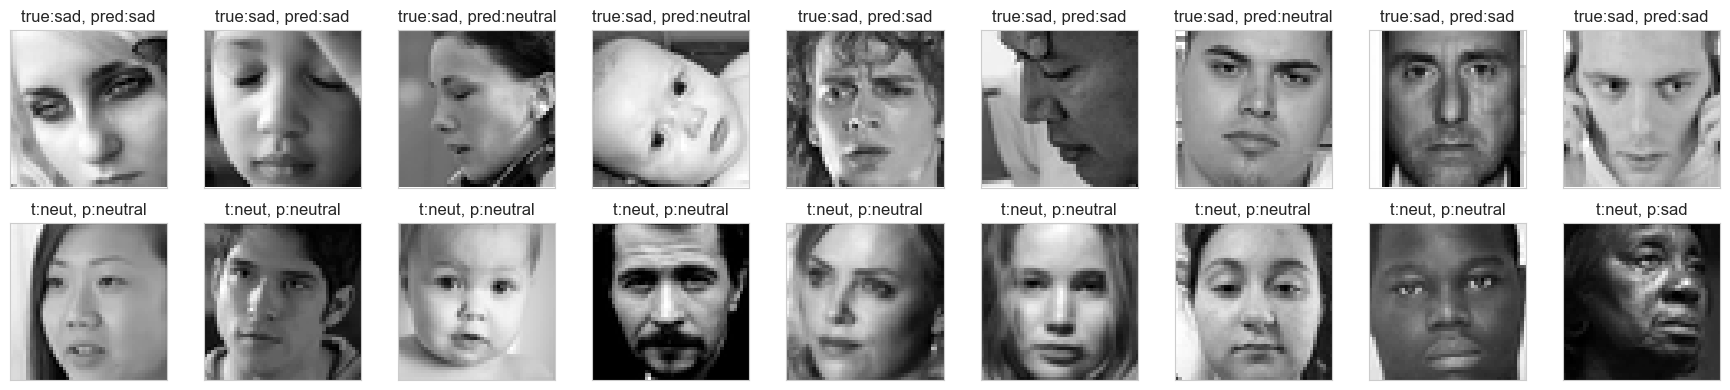

In [61]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        # Use model.predict() instead of deprecated predict_classes()
        pred_probs = model.predict(sample_img.reshape(1,48,48,1), verbose=0)
        pred_class = np.argmax(pred_probs[0])
        ax.set_title(f"true:sad, pred:{mapper[pred_class]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        # Use model.predict() instead of deprecated predict_classes()
        pred_probs = model.predict(sample_img.reshape(1,48,48,1), verbose=0)
        pred_class = np.argmax(pred_probs[0])
        ax.set_title(f"t:neut, p:{mapper[pred_class]}")

        pyplot.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

## 🎥 Simple Camera Test - Run This First!

Before running the emotion detection, test if your camera works:


Testing camera connection...

Trying AVFoundation backend...


2025-10-29 08:15:00.397 Python[57917:4525541] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


✓ Opened with AVFoundation
Waiting for camera to initialize...
  Attempt 1...
✓ Successfully read frame!

✓ Camera working with AVFoundation!
Frame dimensions: (480, 640, 3)


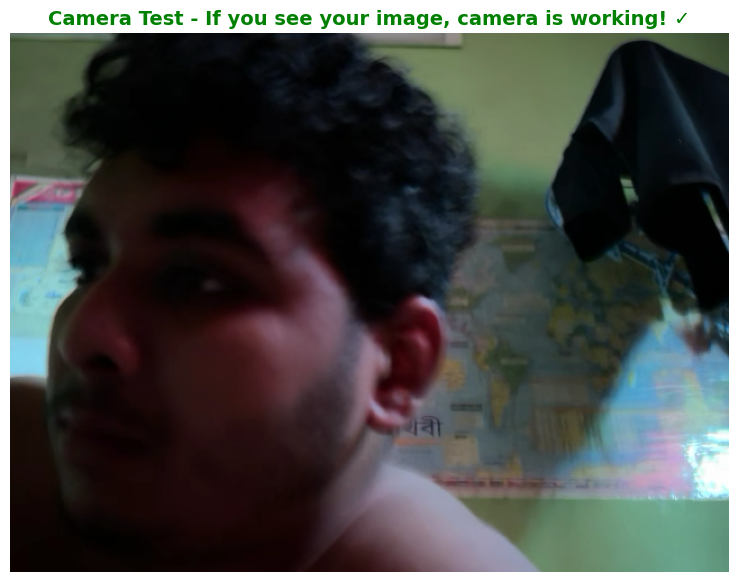


✓ Test complete! Camera is ready for emotion detection.



In [1]:
# Simple Camera Test - Verify your camera works
import cv2
import matplotlib.pyplot as plt
import time

print("Testing camera connection...")

# Try different camera backends on macOS
backends = [
    (cv2.CAP_AVFOUNDATION, 'AVFoundation'),  # macOS native
    (cv2.CAP_ANY, 'Any'),  # Default
]

cap = None
backend_used = None
frame = None
ret = False

for backend_value, backend_name in backends:
    print(f"\nTrying {backend_name} backend...")
    cap = cv2.VideoCapture(backend_value)
    
    if cap.isOpened():
        print(f"✓ Opened with {backend_name}")
        
        # Configure camera
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        
        # Give camera time to initialize
        print("Waiting for camera to initialize...")
        time.sleep(1)  # Wait 1 second for camera to be ready
        
        # Try reading multiple times
        for attempt in range(3):
            print(f"  Attempt {attempt + 1}...")
            ret, frame = cap.read()
            if ret:
                print(f"✓ Successfully read frame!")
                backend_used = backend_name
                break
            time.sleep(0.5)  # Wait 0.5 seconds between attempts
        
        if ret:
            break
        else:
            cap.release()
            cap = None

if not cap or not ret:
    print("\n❌ Failed to access camera after trying multiple methods")
    print("\nTroubleshooting steps:")
    print("1. Check camera permissions in System Settings > Privacy & Security > Camera")
    print("2. Close other apps using the camera (Zoom, FaceTime, Photo Booth, etc.)")
    print("3. Restart your Jupyter kernel (Kernel > Restart Kernel)")
    print("4. On macOS, try running this from Terminal: pip install opencv-python --upgrade")
else:
    print(f"\n✓ Camera working with {backend_used}!")
    print(f"Frame dimensions: {frame.shape}")
    
    # Convert BGR to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame
    plt.figure(figsize=(10, 7))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title('Camera Test - If you see your image, camera is working! ✓', 
             fontsize=14, fontweight='bold', color='green')
    plt.show()
    
    # Release camera
    cap.release()
    print("\n✓ Test complete! Camera is ready for emotion detection.")

print("\n" + "="*60)


# Real-Time Emotion Detection

## Enhanced Information Display

The real-time detection cells now display comprehensive information on each frame:

**📅 Date & Time:** Current date and time timestamp
**⏱️ Session Info:** Elapsed time, frame count, and FPS (frames per second)
**🖥️ System Info:** Device hostname and number of faces detected
**😊 Emotion & Confidence:** Detected emotion with confidence percentage
**📹 Camera Selection:** Active camera index

### Camera Setup Instructions

**For Laptop Camera:**
- Usually camera index 0 (default)
- Run the cell below as is

**For iPhone Camera:**
**Option 1: EpocCam/Camo (Recommended)**
1. Install EpocCam or Camo app on your iPhone
2. Install EpocCam or Camo software on your Mac/PC
3. Connect iPhone via USB or WiFi
4. Use camera index 1 or 2 (run Cell 36 first to find the correct index)

**Option 2: IP Webcam**
1. Install "IP Webcam" app on iPhone
2. Start server in the app
3. Use the IP address shown in the app
4. Update the URL in the camera cell (see instructions below)

### Choose one of the options below:
1. **Cell 36**: List available cameras and select device
2. **Cell 37**: Standard OpenCV window with enhanced information display
3. **Cell 39**: Jupyter Notebook inline display with full information overlay
4. **Cell 41**: Quick single-frame test (for debugging)


In [ ]:
# Real-Time Emotion Detection with Enhanced Information Display
import cv2
import os
import time
from datetime import datetime
import socket

# Load the saved model if available, otherwise use the trained model
try:
    model = tf.keras.models.load_model('model.h5')
    print("Model loaded from model.h5")
except:
    print("Using the currently trained model")
    pass

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start video capture
cap = cv2.VideoCapture(0)

# Get system information
try:
    hostname = socket.gethostname()
    ip_address = socket.gethostbyname(hostname)
except:
    hostname = "Unknown"
    ip_address = "Unknown"

print("Camera started! Press 'q' to quit.")

# Performance tracking
start_time = time.time()
frame_count = 0
prev_time = time.time()
fps = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Calculate FPS
    current_time = time.time()
    frame_count += 1
    if current_time - prev_time >= 1.0:
        fps = frame_count / (current_time - prev_time)
        frame_count = 0
        prev_time = current_time
    
    # Get current time
    current_datetime = datetime.now()
    date_str = current_datetime.strftime("%Y-%m-%d")
    time_str = current_datetime.strftime("%H:%M:%S")
    
    # Get elapsed time
    elapsed_time = time.time() - start_time
    elapsed_min = int(elapsed_time // 60)
    elapsed_sec = int(elapsed_time % 60)
    
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        # Extract face region
        roi_gray = gray[y:y+h, x:x+w]
        
        # Resize to match model input (48x48)
        roi_resized = cv2.resize(roi_gray, (48, 48))
        
        # Normalize pixel values
        roi_normalized = roi_resized.reshape(1, 48, 48, 1) / 255.0
        
        # Make prediction
        predictions = model.predict(roi_normalized, verbose=0)
        emotion_idx = np.argmax(predictions[0])
        emotion = mapper[emotion_idx]
        confidence = predictions[0][emotion_idx]
        
        # Draw rectangle around face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Display emotion and confidence
        label = f"{emotion}: {confidence:.2%}"
        cv2.putText(frame, label, (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    # Display information at the top
    info_y = 20
    line_height = 25
    
    # Display Date and Time
    cv2.putText(frame, f"Date: {date_str} | Time: {time_str}", 
               (10, info_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
    
    # Display Session Info
    info_y += line_height
    cv2.putText(frame, f"Session: {elapsed_min:02d}m {elapsed_sec:02d}s | Frames: {frame_count} | FPS: {fps:.1f}", 
               (10, info_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Display System Info
    info_y += line_height
    cv2.putText(frame, f"Device: {hostname} | Detections: {len(faces)} face(s)", 
               (10, info_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Display the frame
    cv2.imshow('Emotion Detection - Enhanced Information Display', frame)
    
    # Break on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
print("Camera stopped.")


Using the currently trained model


2025-10-29 08:16:26.614 Python[57933:4527379] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Camera started! Press 'q' to quit.


NameError: name 'model' is not defined

: 

## 📷 Live Camera Test - Simple Version

**Run the next cell to test real-time emotion detection!**

This will:
- Open your webcam
- Detect your face in real-time
- Show your emotion: 😊 Happy, 😢 Sad, or 😐 Neutral
- Display confidence percentage

**Press 'q' to quit the camera**

*Note: Make sure you allow camera access when prompted*


In [63]:
# Simple Real-Time Emotion Detection - Webcam Test
import cv2
import time

# Make sure model is available
if 'model' not in locals():
    try:
        model = tf.keras.models.load_model('model.h5')
        print("✓ Model loaded successfully")
    except:
        print("❌ Model not found. Please train the model first!")
        raise

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start camera (try index 0)
cap = cv2.VideoCapture(0)

print("\n" + "="*60)
print("🎥 LIVE EMOTION DETECTION")
print("="*60)
print("\nInstructions:")
print("• Press 'q' to quit")
print("• Make facial expressions to test emotion detection")
print("• Camera will detect: Happy, Sad, or Neutral emotions")
print("\nStarting camera in 2 seconds...")
time.sleep(2)

# Emotion mapping
emotion_labels = ["😊 Happy", "😢 Sad", "😐 Neutral"]

start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to read from camera")
        break
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        # Extract face region
        roi_gray = gray[y:y+h, x:x+w]
        
        # Resize to model input size (48x48)
        roi_resized = cv2.resize(roi_gray, (48, 48))
        roi_normalized = roi_resized.reshape(1, 48, 48, 1) / 255.0
        
        # Predict emotion
        predictions = model.predict(roi_normalized, verbose=0)
        emotion_idx = np.argmax(predictions[0])
        confidence = predictions[0][emotion_idx]
        
        # Get emotion name
        emotion = emotion_labels[emotion_idx]
        
        # Draw green rectangle around face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        # Display emotion and confidence
        label = f"{emotion} ({confidence:.0%})"
        cv2.putText(frame, label, (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display session info
    elapsed = int(time.time() - start_time)
    cv2.putText(frame, f"Running: {elapsed}s | Faces: {len(faces)}", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Show frame
    cv2.imshow('Live Emotion Detection - Press Q to quit', frame)
    
    # Quit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("\n✓ Stopping camera...")
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()

elapsed_time = int(time.time() - start_time)
print(f"\n✓ Session ended. Duration: {elapsed_time} seconds")
print("="*60)


🎥 LIVE EMOTION DETECTION

Instructions:
• Press 'q' to quit
• Make facial expressions to test emotion detection
• Camera will detect: Happy, Sad, or Neutral emotions

Starting camera in 2 seconds...
Failed to read from camera

✓ Session ended. Duration: 1 seconds


In [ ]:
"""
live_emotion_threaded.py
Threaded real-time emotion detection to avoid freezing.

Usage:
  python live_emotion_threaded.py

Requirements:
  pip install opencv-python numpy tensorflow
  Put model.h5 in the same folder or set MODEL_PATH. If no model, runs in face-only mode.

Notes:
 - This uses one background worker thread to run model.predict().
 - The main thread handles capture, face detection, drawing, and display.
"""

import cv2
import os
import time
from datetime import datetime
import socket
import numpy as np
import threading
from queue import Queue, Full, Empty
from collections import deque, Counter

# ---------- Config ----------
MODEL_PATH = "model.h5"
USE_MODEL = True
SMOOTHING_WINDOW = 7
BAR_WIDTH = 220
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
NUM_CLASSES = len(EMOTIONS)
MAX_QUEUE_SIZE = 4          # keep small to avoid backlog
ROI_SIZE = (48, 48)         # model input size
CAPTURE_WIDTH = 640         # resize capture frame width for speed (keep aspect ratio)
FONT = cv2.FONT_HERSHEY_SIMPLEX
# ----------------------------

# Load model safely
model = None
model_lock = threading.Lock()
if USE_MODEL:
    try:
        import tensorflow as tf
        model = tf.keras.models.load_model(MODEL_PATH)
        print(f"Model loaded: {MODEL_PATH}")
    except Exception as e:
        print("Model load failed:", e)
        model = None
else:
    print("Running without model (face-only).")
    model = None

# Face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    raise RuntimeError("Failed to load Haar cascade.")

# Camera open
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera. Try different index or check permissions.")

# Try to set capture width for speed (may be ignored by some backends)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, CAPTURE_WIDTH)

# System info
try:
    hostname = socket.gethostname()
except:
    hostname = "Unknown"

# Queues and shared structures
task_queue = Queue(maxsize=MAX_QUEUE_SIZE)     # items: (frame_id, roi_gray_resized)
result_dict = {}  # frame_id -> (probs array, timestamp)
result_lock = threading.Lock()
global_predictions = deque(maxlen=SMOOTHING_WINDOW)

stop_event = threading.Event()

def inference_worker():
    """Background thread: takes ROIs from task_queue, runs model.predict, saves to result_dict."""
    while not stop_event.is_set():
        try:
            frame_id, roi = task_queue.get(timeout=0.2)
        except Empty:
            continue
        if model is None:
            # no model: put None result
            with result_lock:
                result_dict[frame_id] = (None, time.time())
            task_queue.task_done()
            continue

        try:
            # Ensure model prediction done under lock (TF thread-safety)
            with model_lock:
                # roi is expected to be already resized (48x48) and grayscale
                x = roi.astype("float32") / 255.0
                x = x.reshape(1, ROI_SIZE[1], ROI_SIZE[0], 1)
                preds = model.predict(x, verbose=0)
            probs = np.squeeze(preds)
            # Normalize defensively
            probs = np.maximum(probs, 0)
            s = probs.sum()
            if s > 0:
                probs = probs / s
        except Exception as e:
            print("Prediction error in worker:", e)
            probs = None

        with result_lock:
            result_dict[frame_id] = (probs, time.time())
        task_queue.task_done()

# Start background worker
worker_thread = threading.Thread(target=inference_worker, daemon=True)
worker_thread.start()

# Drawing helper: simple bars
def draw_probability_bars(canvas, probs, x0, y0, w, h, emotions):
    if probs is None:
        cv2.putText(canvas, "No model loaded", (x0 + 10, y0 + 30), FONT, 0.6, (0,0,255), 2)
        return
    n = len(emotions)
    bar_h = 18
    padding = 12
    y = y0 + padding
    for i, label in enumerate(emotions):
        p = float(probs[i])
        # label
        cv2.putText(canvas, f"{label[:10]:10s}", (x0 + 6, y + 13), FONT, 0.45, (230,230,230), 1)
        cv2.rectangle(canvas, (x0 + 80, y), (x0 + w - 10, y + bar_h), (50,50,50), -1)
        fill_w = int((w - 100) * p)
        cv2.rectangle(canvas, (x0 + 80, y), (x0 + 80 + fill_w, y + bar_h), (0,150,255), -1)
        cv2.putText(canvas, f"{p*100:5.1f}%", (x0 + w - 60, y + 13), FONT, 0.45, (255,255,255), 1)
        y += bar_h + 8

# Main loop
start_time = time.time()
frame_counter = 0
prev_time = time.time()
fps = 0.0
frame_id = 0

print("Camera started. Press 'q' to quit, 's' to save snapshot.")

snapshot_dir = "snapshots"
os.makedirs(snapshot_dir, exist_ok=True)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame.")
            break

        # Resize to fixed width for speed, keep ratio
        h0, w0 = frame.shape[:2]
        if w0 != CAPTURE_WIDTH:
            scale = CAPTURE_WIDTH / float(w0)
            frame = cv2.resize(frame, (CAPTURE_WIDTH, int(h0 * scale)))
        h, w = frame.shape[:2]

        frame_counter += 1
        now = time.time()
        if now - prev_time >= 1.0:
            fps = frame_counter / (now - prev_time)
            frame_counter = 0
            prev_time = now

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        # Prepare canvas with right-side bar area
        canvas = np.zeros((h, w + BAR_WIDTH, 3), dtype=np.uint8)
        canvas[:, :w] = frame

        any_prediction = False
        frame_probs_sum = np.zeros(NUM_CLASSES, dtype=float)

        # For each face, try to enqueue ROI for prediction (non-blocking)
        # We'll tag the task with current frame_id (so results are per-frame)
        current_frame_id = frame_id = (frame_id + 1) % 1000000

        for (x, y, fw, fh) in faces:
            pad = max(2, int(0.08 * fw))
            x1 = max(0, x - pad)
            y1 = max(0, y - pad)
            x2 = min(w, x + fw + pad)
            y2 = min(h, y + fh + pad)
            roi_gray = gray[y1:y2, x1:x2]

            # Resize ROI to model size BEFORE enqueue to keep worker fast
            try:
                roi_small = cv2.resize(roi_gray, ROI_SIZE)
            except Exception:
                roi_small = cv2.resize(roi_gray, ROI_SIZE, interpolation=cv2.INTER_AREA)

            # Try enqueueing; if queue full, skip to avoid backlog
            try:
                task_queue.put_nowait((current_frame_id, roi_small))
            except Full:
                # Skip prediction this face this frame (keeps UI responsive)
                pass

            # Draw rectangle (we will overlay label later if result available)
            cv2.rectangle(canvas, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Collect result for this frame_id if available
        probs = None
        with result_lock:
            entry = result_dict.pop(current_frame_id, None)
        if entry is not None:
            probs, ts = entry
            if probs is not None:
                any_prediction = True
                # If multiple faces present, we only enqueued same frame_id multiple times;
                # worker will overwrite result_dict for same frame_id with last processed face.
                # To keep it simple, treat returned probs as representative for frame (dominant).
                frame_probs_sum += probs

        # Determine dominant emotion using smoothing
        dominant = "N/A"
        dominant_conf = 0.0
        if any_prediction:
            avg_probs = frame_probs_sum / max(1, len(faces))
            dom_idx = int(np.argmax(avg_probs))
            global_predictions.append(dom_idx)
            counts = Counter(global_predictions)
            most_common_idx, _ = counts.most_common(1)[0]
            dominant = EMOTIONS[most_common_idx]
            dominant_conf = avg_probs[most_common_idx]
        else:
            # no prediction: we can optionally clear smoothing after timeout
            pass

        # Right-side overlay
        overlay_x0 = w
        overlay_y0 = 10
        cv2.putText(canvas, "Emotion Live", (overlay_x0 + 10, overlay_y0 + 18), FONT, 0.8, (200,200,255), 2)
        cv2.putText(canvas, f"Device: {hostname}", (overlay_x0 + 10, overlay_y0 + 40), FONT, 0.5, (180,180,180), 1)
        cv2.putText(canvas, f"Detections: {len(faces)}", (overlay_x0 + 10, overlay_y0 + 60), FONT, 0.5, (180,180,180), 1)
        elapsed = int(time.time() - start_time)
        cv2.putText(canvas, f"Session: {elapsed//60:02d}m {elapsed%60:02d}s", (overlay_x0 + 10, overlay_y0 + 82), FONT, 0.5, (180,180,180), 1)
        cv2.putText(canvas, f"FPS: {fps:.1f}", (overlay_x0 + 10, overlay_y0 + 102), FONT, 0.5, (180,180,180), 1)

        cv2.putText(canvas, f"Dominant: {dominant}", (overlay_x0 + 10, overlay_y0 + 132), FONT, 0.6, (0,230,0), 2)
        cv2.putText(canvas, f"Confidence: {dominant_conf*100:4.1f}%", (overlay_x0 + 10, overlay_y0 + 156), FONT, 0.5, (200,200,200), 1)

        avg_probs = (frame_probs_sum / max(1, len(faces))).astype(float) if any_prediction else None
        draw_probability_bars(canvas, avg_probs, overlay_x0 + 6, overlay_y0 + 170, BAR_WIDTH - 12, h - 190, EMOTIONS)

        cv2.imshow("Emotion Detection (Threaded)", canvas)

        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break
        elif key == ord("s"):
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fn = os.path.join(snapshot_dir, f"snapshot_{timestamp}.png")
            cv2.imwrite(fn, canvas)
            print("Snapshot saved:", fn)

finally:
    # Shutdown
    stop_event.set()
    # Wait a little for worker to exit
    try:
        worker_thread.join(timeout=1.0)
    except:
        pass
    cap.release()
    cv2.destroyAllWindows()
    print("Exited cleanly.")

Model loaded: model.h5


2025-10-29 08:19:30.399 Python[57963:4530485] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Camera started. Press 'q' to quit, 's' to save snapshot.
Exited cleanly.


: 

## Quick Test: Capture Single Image and Predict


Available camera options:
0: Laptop/Desktop built-in camera (default)
1: External camera (e.g., iPhone via Continuity Camera)
2: Other external camera

Capturing from camera 1...
Detected emotion: neutral with confidence: 0.52


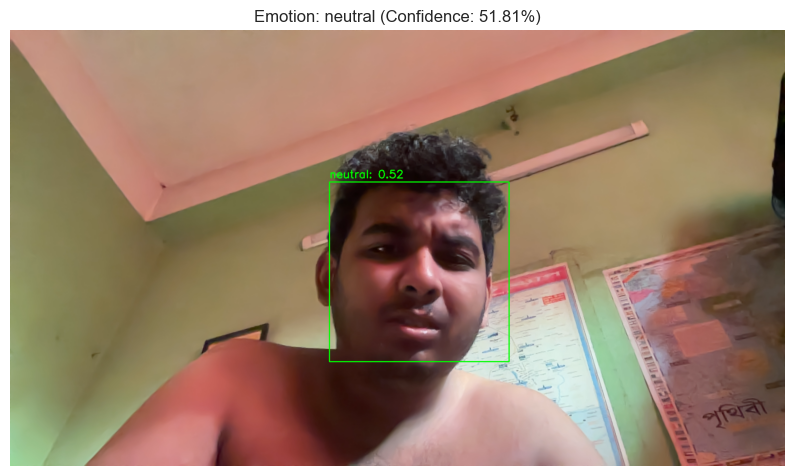

In [64]:
# Quick Test: Capture and analyze a single frame
import cv2
from matplotlib import pyplot as plt

# Make sure model is available
if 'model' not in locals():
    try:
        model = tf.keras.models.load_model('model.h5')
        print("Model loaded from model.h5")
    except:
        print("Please train the model first!")
        raise

# Camera Selection
print("Available camera options:")
print("0: Laptop/Desktop built-in camera (default)")
print("1: External camera (e.g., iPhone via Continuity Camera)")
print("2: Other external camera")

camera_choice = input("Enter camera number (0-2, or press Enter for default 0): ")
if camera_choice.strip() == "":
    camera_index = 0
else:
    camera_index = int(camera_choice)

# Capture a single frame
print(f"\nCapturing from camera {camera_index}...")
cap = cv2.VideoCapture(camera_index)
ret, frame = cap.read()
cap.release()

if ret:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Show the frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Extract and process face
            roi_gray = gray[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi_gray, (48, 48))
            roi_normalized = roi_resized.reshape(1, 48, 48, 1) / 255.0
            
            # Predict
            predictions = model.predict(roi_normalized, verbose=0)
            emotion_idx = np.argmax(predictions[0])
            emotion = mapper[emotion_idx]
            confidence = predictions[0][emotion_idx]
            
            # Draw rectangle and label
            cv2.rectangle(frame_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame_rgb, f"{emotion}: {confidence:.2f}", (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        print(f"Detected emotion: {emotion} with confidence: {confidence:.2f}")
        plt.figure(figsize=(10, 8))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f'Emotion: {emotion} (Confidence: {confidence:.2%})')
        plt.show()
    else:
        print("No face detected in the captured frame.")
        plt.figure(figsize=(10, 8))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title('No face detected')
        plt.show()
else:
    print("Failed to capture image from camera")


In [ ]:
# camera_test.py — diagnostic (run in terminal)
import cv2, sys, time, platform

print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())

try:
    print("OpenCV version:", cv2.__version__)
except Exception as e:
    print("Could not import cv2:", e)
    raise

# Print available backends on this build (if available)
try:
    backends = [
        ("CAP_ANY", cv2.CAP_ANY),
        ("CAP_V4L2", getattr(cv2, "CAP_V4L2", None)),
        ("CAP_DSHOW", getattr(cv2, "CAP_DSHOW", None)),
        ("CAP_MSMF", getattr(cv2, "CAP_MSMF", None)),
        ("CAP_AVFOUNDATION", getattr(cv2, "CAP_AVFOUNDATION", None)),
        ("CAP_GSTREAMER", getattr(cv2, "CAP_GSTREAMER", None)),
        ("CAP_FFMPEG", getattr(cv2, "CAP_FFMPEG", None)),
    ]
    print("Backends available in cv2 build (names and constants):")
    for name, val in backends:
        print(" ", name, "=", val)
except Exception:
    pass

def try_open(index, api_preference=None):
    if api_preference is None:
        cap = cv2.VideoCapture(index)
    else:
        cap = cv2.VideoCapture(index, api_preference)
    ok = cap.isOpened()
    print(f"\nTrying index={index}, api_preference={api_preference} -> isOpened: {ok}")
    if not ok:
        try:
            cap.release()
        except:
            pass
        return False
    # Try read a frame
    ret, frame = cap.read()
    print("  read returned:", ret, " frame is None?:", frame is None)
    if ret and frame is not None:
        print("  frame shape:", getattr(frame, "shape", None))
        # show for 1 second (optional)
        cv2.imshow(f"Test idx {index}", frame)
        cv2.waitKey(1000)
        cv2.destroyAllWindows()
    cap.release()
    return ret

# Try a few indices and common api backends
indices = [0, 1, 2, 3]
api_candidates = [None]

# Add platform-specific preferred APIs
plat = platform.system()
if plat == "Windows":
    api_candidates += [cv2.CAP_DSHOW, cv2.CAP_MSMF, cv2.CAP_ANY]
elif plat == "Darwin":
    api_candidates += [cv2.CAP_AVFOUNDATION, cv2.CAP_ANY]
else:  # Linux / others
    api_candidates += [cv2.CAP_V4L2, cv2.CAP_ANY, cv2.CAP_GSTREAMER]

results = {}
for api in api_candidates:
    for idx in indices:
        ok = try_open(idx, api)
        results[(idx, api)] = ok

print("\nSummary of attempts:")
for (idx, api), ok in results.items():
    print(" index:", idx, "api:", api, "->", ok)

print("\nIf all attempts failed:\n - check camera permissions again\n - try running a native camera app (Camera/PhotoBooth/cheese)\n - check drivers (Device Manager on Windows) or add user to video group on Linux\n - ensure opencv-python (GUI build) is installed: pip show opencv-python")

Python: 3.13.0 (v3.13.0:60403a5409f, Oct  7 2024, 00:37:40) [Clang 15.0.0 (clang-1500.3.9.4)]
Platform: macOS-15.4.1-arm64-arm-64bit-Mach-O
OpenCV version: 4.12.0
Backends available in cv2 build (names and constants):
  CAP_ANY = 0
  CAP_V4L2 = 200
  CAP_DSHOW = 700
  CAP_MSMF = 1400
  CAP_AVFOUNDATION = 1200
  CAP_GSTREAMER = 1800
  CAP_FFMPEG = 1900

Trying index=0, api_preference=None -> isOpened: True
  read returned: False  frame is None?: True

Trying index=1, api_preference=None -> isOpened: True
  read returned: True  frame is None?: False
  frame shape: (1080, 1920, 3)


OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 3
OpenCV: camera failed to properly initialize!



Trying index=2, api_preference=None -> isOpened: False

Trying index=3, api_preference=None -> isOpened: False

Trying index=0, api_preference=1200 -> isOpened: True
  read returned: True  frame is None?: False
  frame shape: (1080, 1920, 3)

Trying index=1, api_preference=1200 -> isOpened: True
  read returned: True  frame is None?: False
  frame shape: (1080, 1920, 3)


OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
[ WARN:0@97032.785] global cap.cpp:480 open VIDEOIO(AVFOUNDATION): backend is generally available but can't be used to capture by index
OpenCV: out device of bound (0-1): 3
OpenCV: camera failed to properly initialize!
[ WARN:0@97032.799] global cap.cpp:480 open VIDEOIO(AVFOUNDATION): backend is generally available but can't be used to capture by index



Trying index=2, api_preference=1200 -> isOpened: False

Trying index=3, api_preference=1200 -> isOpened: False

Trying index=0, api_preference=0 -> isOpened: True
  read returned: True  frame is None?: False
  frame shape: (1080, 1920, 3)

Trying index=1, api_preference=0 -> isOpened: True
  read returned: True  frame is None?: False
  frame shape: (1080, 1920, 3)

Trying index=2, api_preference=0 -> isOpened: False

Trying index=3, api_preference=0 -> isOpened: False

Summary of attempts:
 index: 0 api: None -> False
 index: 1 api: None -> True
 index: 2 api: None -> False
 index: 3 api: None -> False
 index: 0 api: 1200 -> True
 index: 1 api: 1200 -> True
 index: 2 api: 1200 -> False
 index: 3 api: 1200 -> False
 index: 0 api: 0 -> True
 index: 1 api: 0 -> True
 index: 2 api: 0 -> False
 index: 3 api: 0 -> False

If all attempts failed:
 - check camera permissions again
 - try running a native camera app (Camera/PhotoBooth/cheese)
 - check drivers (Device Manager on Windows) or add 

OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 3
OpenCV: camera failed to properly initialize!


: 

In [ ]:
"""
live_emotion_detection.py
Complete real-time emotion detection with enhanced UI and smoothing.

Requirements:
 - Python 3.8+
 - pip install opencv-python numpy tensorflow  (if you have a model)
 - Put your Keras model file as 'model.h5' in same folder (optional)
"""

import cv2
import os
import time
from datetime import datetime
import socket
import numpy as np
from collections import deque, Counter

# --- Configuration ---
MODEL_PATH = "model.h5"          # change if your model filename differs
USE_MODEL = True                 # if False, runs in face-only mode
SMOOTHING_WINDOW = 7             # number of recent predictions to smooth dominant emotion
BAR_WIDTH = 220                  # width of the right-side probability bar area
FONT = cv2.FONT_HERSHEY_SIMPLEX

# Example mapper: adjust ordering to match your model's output nodes
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
NUM_CLASSES = len(EMOTIONS)

# --- Load TensorFlow model safely (optional) ---
model = None
if USE_MODEL:
    try:
        import tensorflow as tf
        model = tf.keras.models.load_model(MODEL_PATH)
        print(f"✅ Model loaded from '{MODEL_PATH}'")
    except Exception as e:
        print(f"⚠️ Unable to load model from '{MODEL_PATH}': {e}")
        print("Running in face-only mode (no predictions).")
        model = None
else:
    model = None
    print("Running in face-only mode by configuration (USE_MODEL=False).")

# --- Face detector ---
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    raise RuntimeError("Failed to load Haar cascade. Check your OpenCV installation.")

# --- Camera open ---
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera. Try different index or check permissions.")

# --- System info ---
try:
    hostname = socket.gethostname()
except:
    hostname = "Unknown"

# Smoothing containers: one deque per detected face id (we use positions to track loosely)
global_predictions = deque(maxlen=SMOOTHING_WINDOW)  # generic smoothing if multiple faces

start_time = time.time()
frame_counter = 0
prev_time = time.time()
fps = 0.0
snapshot_dir = "snapshots"
os.makedirs(snapshot_dir, exist_ok=True)

print("Camera started. Press 'q' to quit, 's' to save snapshot.")

def predict_emotion(roi_gray):
    """
    Input: grayscale face region (numpy array)
    Output: probs (1D numpy array length NUM_CLASSES)
    """
    if model is None:
        return None
    try:
        # Resize to model input size. Most facial expression models use 48x48 grayscale.
        roi_resized = cv2.resize(roi_gray, (48, 48))
        roi_normalized = roi_resized.astype("float32") / 255.0
        roi_normalized = roi_normalized.reshape(1, 48, 48, 1)
        preds = model.predict(roi_normalized, verbose=0)
        probs = np.squeeze(preds)
        # Ensure length matches EMOTIONS
        if probs.shape[0] != NUM_CLASSES:
            # Attempt to adapt if shape mismatch
            probs = np.resize(probs, NUM_CLASSES)
        # Normalize to sum=1 (in case)
        probs = np.maximum(probs, 0)
        s = probs.sum()
        if s > 0:
            probs = probs / s
        return probs
    except Exception as e:
        # Don't crash if prediction fails
        print("Prediction error:", e)
        return None

def draw_probability_bars(canvas, probs, x0, y0, w, h, emotions):
    """
    Draw vertical bars on the provided canvas (right-side) showing probabilities.
    canvas: image to draw on
    probs: 1D array length = len(emotions)
    x0,y0 top-left of area, w,h size of area
    """
    if probs is None:
        # show a message
        cv2.putText(canvas, "No model loaded", (x0 + 10, y0 + 30), FONT, 0.6, (0,0,255), 2)
        return

    n = len(emotions)
    bar_h = 18
    padding = 12
    y = y0 + padding
    for i, label in enumerate(emotions):
        p = float(probs[i])
        # label text
        cv2.putText(canvas, f"{label[:10]:10s}", (x0 + 6, y + 13), FONT, 0.45, (230,230,230), 1)
        # background rect
        cv2.rectangle(canvas, (x0 + 80, y), (x0 + w - 10, y + bar_h), (50,50,50), -1)
        # filled rect proportional to probability
        fill_w = int((w - 100) * p)
        cv2.rectangle(canvas, (x0 + 80, y), (x0 + 80 + fill_w, y + bar_h), (0,150,255), -1)
        # percentage text
        cv2.putText(canvas, f"{p*100:5.1f}%", (x0 + w - 60, y + 13), FONT, 0.45, (255,255,255), 1)
        y += bar_h + 8

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to read frame from camera.")
        break

    frame_counter += 1
    now = time.time()
    if now - prev_time >= 1.0:
        fps = frame_counter / (now - prev_time)
        frame_counter = 0
        prev_time = now

    # Prepare canvas wider to include probability bars on right
    h, w = frame.shape[:2]
    canvas = np.zeros((h, w + BAR_WIDTH, 3), dtype=np.uint8)
    canvas[:, :w] = frame  # put camera frame on left

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # We'll aggregate predictions per frame for a single "dominant across faces"
    frame_probs_sum = np.zeros(NUM_CLASSES, dtype=float)
    any_prediction = False

    for (x, y, fw, fh) in faces:
        # Expand box slightly for better face crop
        pad = int(0.1 * fw)
        x1 = max(0, x - pad)
        y1 = max(0, y - pad)
        x2 = min(w, x + fw + pad)
        y2 = min(h, y + fh + pad)
        roi_gray = gray[y1:y2, x1:x2]
        probs = predict_emotion(roi_gray)  # may return None if model missing/error

        # Draw face rectangle in left area (on canvas)
        cv2.rectangle(canvas, (x1, y1), (x2, y2), (255, 0, 0), 2)

        if probs is not None:
            any_prediction = True
            frame_probs_sum += probs
            # Find top emotion for this face
            idx = int(np.argmax(probs))
            emo = EMOTIONS[idx]
            conf = probs[idx]
            label = f"{emo} {conf*100:4.1f}%"
        else:
            label = "NoModel"

        # Put label above box
        cv2.putText(canvas, label, (x1, max(10, y1 - 8)),
                    FONT, 0.6, (255, 200, 0), 2)

    # Determine dominant emotion across faces using smoothing
    dominant = "N/A"
    dominant_conf = 0.0
    if any_prediction:
        # average probs across faces in this frame
        avg_probs = frame_probs_sum / max(1, len(faces))
        # push dominant index into smoothing deque
        dom_idx = int(np.argmax(avg_probs))
        global_predictions.append(dom_idx)
        # compute smoothed majority
        counts = Counter(global_predictions)
        most_common_idx, _ = counts.most_common(1)[0]
        dominant = EMOTIONS[most_common_idx]
        # estimate confidence as average probability of that class across recent frames
        # (we can't recalc per frame historically, so approximate by avg_probs)
        dominant_conf = avg_probs[most_common_idx]
    else:
        # no prediction (no model or no faces)
        if len(global_predictions) > 0:
            # slowly decay smoothing
            global_predictions.clear()

    # Draw info overlays on right-side area (canvas has width w + BAR_WIDTH)
    overlay_x0 = w
    overlay_y0 = 10
    # header
    cv2.putText(canvas, "Emotion Live", (overlay_x0 + 10, overlay_y0 + 18), FONT, 0.8, (200,200,255), 2)
    cv2.putText(canvas, f"Device: {hostname}", (overlay_x0 + 10, overlay_y0 + 40), FONT, 0.5, (180,180,180), 1)
    cv2.putText(canvas, f"Detections: {len(faces)}", (overlay_x0 + 10, overlay_y0 + 60), FONT, 0.5, (180,180,180), 1)

    # session time & fps
    elapsed = int(time.time() - start_time)
    em = f"{elapsed//60:02d}m {elapsed%60:02d}s"
    cv2.putText(canvas, f"Session: {em}", (overlay_x0 + 10, overlay_y0 + 82), FONT, 0.5, (180,180,180), 1)
    cv2.putText(canvas, f"FPS: {fps:.1f}", (overlay_x0 + 10, overlay_y0 + 102), FONT, 0.5, (180,180,180), 1)

    # Dominant emotion display
    cv2.putText(canvas, f"Dominant: {dominant}", (overlay_x0 + 10, overlay_y0 + 132), FONT, 0.6, (0,230,0), 2)
    cv2.putText(canvas, f"Confidence: {dominant_conf*100:4.1f}%", (overlay_x0 + 10, overlay_y0 + 156), FONT, 0.5, (200,200,200), 1)

    # Draw probability bars for the last-frame average if available (else None)
    avg_probs = None
    if any_prediction:
        avg_probs = (frame_probs_sum / max(1, len(faces))).astype(float)
    draw_probability_bars(canvas, avg_probs, overlay_x0 + 6, overlay_y0 + 170, BAR_WIDTH - 12, h - 190, EMOTIONS)

    # Show combined canvas
    cv2.imshow("Emotion Detection (Live)", canvas)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        print("Quitting.")
        break
    elif key == ord("s"):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = os.path.join(snapshot_dir, f"snapshot_{timestamp}.png")
        cv2.imwrite(filename, canvas)
        print("Saved snapshot:", filename)

# Clean up
cap.release()
cv2.destroyAllWindows()
print("Camera stopped.")

✅ Model loaded from 'model.h5'
Camera started. Press 'q' to quit, 's' to save snapshot.
Quitting.
Camera stopped.


: 